1. torchvision을 사용하여 CIFAR10의 학습용 데이터, 시험용 데이터 불러오기, 정규화
2. 합성곱 신경망 정의
3. 손실 함수 정의
4. 학습용 데이터를 사용하여 신경망 학습
5. 시험용 데이터를 사용하여 신경망 검사

In [1]:
#결과 inline에 출력
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

batch_size = 2048

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers= 8 ,pin_memory= True)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8, pin_memory= True)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
               'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

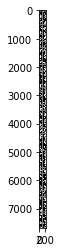

T-shirt/top Pullover Trouser Sandal   Bag  Coat Sneaker Shirt T-shirt/top T-shirt/top Shirt T-shirt/top  Coat Pullover T-shirt/top Shirt   Bag Sandal   Bag Ankle boot Trouser Sandal Trouser   Bag Shirt Sandal Sneaker Pullover Sandal Pullover Ankle boot  Coat Dress   Bag Sandal  Coat Sandal Sandal Pullover   Bag Ankle boot Ankle boot Pullover  Coat Shirt Ankle boot   Bag   Bag Sneaker Sneaker Sneaker Sneaker Pullover Sandal Sneaker Shirt Sandal Sneaker Ankle boot Sandal Dress T-shirt/top T-shirt/top T-shirt/top   Bag Pullover  Coat Sneaker Pullover  Coat Sneaker T-shirt/top Dress Sneaker Sandal Ankle boot Ankle boot  Coat T-shirt/top Sneaker  Coat T-shirt/top  Coat Ankle boot   Bag Sneaker   Bag Trouser  Coat Ankle boot Shirt  Coat Dress T-shirt/top Ankle boot   Bag T-shirt/top Sneaker Shirt Ankle boot Sandal T-shirt/top T-shirt/top Sandal Trouser Ankle boot Ankle boot T-shirt/top T-shirt/top Pullover Ankle boot Trouser Sneaker   Bag Sandal   Bag Trouser Shirt Sandal   Bag Trouser Shirt

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
print(dataiter)
images, labels = dataiter.next()
# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
          nn.Conv2d(1, 32, 3),
          nn.ReLU(),
          nn.Conv2d(32, 32, 3),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
          nn.Dropout(0.2)
        )

        self.layer2 = torch.nn.Sequential(
          nn.Conv2d(32, 64, 3),
          nn.ReLU(),
          nn.Conv2d(64, 64, 3),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
          nn.Dropout(0.2)
        )


        self.fc1 = nn.Linear(1024, 120)
        self.bn1 = nn.BatchNorm1d(120)
        self.bn2 = nn.BatchNorm1d(84)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x


net = Net()

if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)

net.to(device)

DataParallel(
  (module): Net(
    (layer1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Dropout(p=0.2, inplace=False)
    )
    (layer2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Dropout(p=0.2, inplace=False)
    )
    (fc1): Linear(in_features=1024, out_features=120, bias=True)
    (bn1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_feat

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [8]:
net.train()
for epoch in range(200):   # 데이터셋을 수차례 반복합니다.
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data[0].to(device), data[1].to(device)

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 1.570
[1,    20] loss: 0.958
[1,    30] loss: 0.760
[2,    10] loss: 0.631
[2,    20] loss: 0.541
[2,    30] loss: 0.470
[3,    10] loss: 0.411
[3,    20] loss: 0.392
[3,    30] loss: 0.363
[4,    10] loss: 0.332
[4,    20] loss: 0.313
[4,    30] loss: 0.328
[5,    10] loss: 0.299
[5,    20] loss: 0.284
[5,    30] loss: 0.278
[6,    10] loss: 0.267
[6,    20] loss: 0.265
[6,    30] loss: 0.260
[7,    10] loss: 0.248
[7,    20] loss: 0.245
[7,    30] loss: 0.245
[8,    10] loss: 0.234
[8,    20] loss: 0.228
[8,    30] loss: 0.239
[9,    10] loss: 0.221
[9,    20] loss: 0.218
[9,    30] loss: 0.222
[10,    10] loss: 0.210
[10,    20] loss: 0.207
[10,    30] loss: 0.202
[11,    10] loss: 0.201
[11,    20] loss: 0.192
[11,    30] loss: 0.196
[12,    10] loss: 0.192
[12,    20] loss: 0.187
[12,    30] loss: 0.189
[13,    10] loss: 0.177
[13,    20] loss: 0.179
[13,    30] loss: 0.185
[14,    10] loss: 0.167
[14,    20] loss: 0.169
[14,    30] loss: 0.183
[15,    10] loss: 0

[114,    30] loss: 0.025
[115,    10] loss: 0.024
[115,    20] loss: 0.023
[115,    30] loss: 0.024
[116,    10] loss: 0.024
[116,    20] loss: 0.022
[116,    30] loss: 0.023
[117,    10] loss: 0.023
[117,    20] loss: 0.024
[117,    30] loss: 0.025
[118,    10] loss: 0.022
[118,    20] loss: 0.022
[118,    30] loss: 0.024
[119,    10] loss: 0.024
[119,    20] loss: 0.022
[119,    30] loss: 0.022
[120,    10] loss: 0.024
[120,    20] loss: 0.025
[120,    30] loss: 0.026
[121,    10] loss: 0.025
[121,    20] loss: 0.025
[121,    30] loss: 0.025
[122,    10] loss: 0.024
[122,    20] loss: 0.023
[122,    30] loss: 0.020
[123,    10] loss: 0.020
[123,    20] loss: 0.022
[123,    30] loss: 0.024
[124,    10] loss: 0.022
[124,    20] loss: 0.024
[124,    30] loss: 0.024
[125,    10] loss: 0.023
[125,    20] loss: 0.019
[125,    30] loss: 0.019
[126,    10] loss: 0.022
[126,    20] loss: 0.019
[126,    30] loss: 0.019
[127,    10] loss: 0.019
[127,    20] loss: 0.021
[127,    30] loss: 0.024


In [9]:
PATH = './fashion_net.pth'
torch.save(net.state_dict(), PATH)

In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
# 이미지를 출력합니다.
# imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(64)))

GroundTruth:  Ankle boot Pullover Trouser Trouser Shirt Trouser  Coat Shirt Sandal Sneaker  Coat Sandal Sneaker Dress  Coat Trouser Pullover  Coat   Bag T-shirt/top Pullover Sandal Sneaker Ankle boot Trouser  Coat Shirt T-shirt/top Ankle boot Dress   Bag   Bag Dress Dress   Bag T-shirt/top Sneaker Sandal Sneaker Ankle boot Shirt Trouser Dress Sneaker Shirt Sneaker Pullover Trouser Pullover Pullover  Coat  Coat Sandal   Bag Pullover Pullover   Bag  Coat   Bag T-shirt/top Sneaker Sneaker   Bag Sandal


In [11]:
# net = Net()
# net.to(device)
# net.load_state_dict(torch.load(PATH))

In [12]:
net.train()
outputs = net(images)

In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch_size)))

Predicted:  Ankle boot Pullover Trouser Trouser Shirt Trouser  Coat Shirt Sandal Sneaker  Coat Sandal Sneaker Dress  Coat Trouser Pullover Shirt   Bag T-shirt/top Pullover Sandal Sneaker Sandal Trouser Shirt Shirt T-shirt/top Ankle boot Dress   Bag   Bag Dress Dress   Bag T-shirt/top Sneaker Sandal Sneaker Ankle boot Shirt Trouser T-shirt/top Ankle boot Shirt Sneaker Pullover Trouser Shirt Shirt  Coat  Coat Sandal   Bag Pullover Pullover   Bag  Coat   Bag T-shirt/top Sneaker Sneaker   Bag Sandal Trouser Trouser Dress Dress Sneaker   Bag Sneaker T-shirt/top Pullover Shirt Pullover Dress Trouser Pullover   Bag  Coat Trouser   Bag Sandal Ankle boot Sandal T-shirt/top Dress Pullover T-shirt/top Shirt Sandal Dress Shirt Sneaker Trouser   Bag T-shirt/top Trouser Pullover Pullover Dress Shirt Sneaker Pullover Sneaker   Bag Sandal Ankle boot Ankle boot  Coat Pullover Sandal Sneaker T-shirt/top Sandal Pullover   Bag  Coat Sneaker   Bag T-shirt/top T-shirt/top Ankle boot Ankle boot Dress T-shirt

In [14]:
net.eval()
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 93 %


In [15]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class T-shirt/top is: 88.7 %
Accuracy for class Trouser is: 98.6 %
Accuracy for class Pullover is: 91.6 %
Accuracy for class Dress is: 93.6 %
Accuracy for class Coat  is: 89.8 %
Accuracy for class Sandal is: 98.2 %
Accuracy for class Shirt is: 79.4 %
Accuracy for class Sneaker is: 98.3 %
Accuracy for class Bag   is: 99.0 %
Accuracy for class Ankle boot is: 96.2 %
